In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


# Set batch size for training and validation
batch_size = 32

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import splitfolders
from keras.preprocessing import image

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/cvice', output="output",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None)

Copying files: 689 files [06:54,  1.66 files/s]


In [ ]:
def preprocess_data(batch_size, img_size):
  #train_gen = image.ImageDataGenerator(rescale = 1./255.)
  train_gen = image.ImageDataGenerator(rescale = 1./255.,
                                      rotation_range=25,
                                      width_shift_range = 0.3,
                                      height_shift_range = 0.25,
                                      zoom_range = 0.3,
                                      horizontal_flip = True,
                                      vertical_flip= True
                                     )
  train_generator = train_gen.flow_from_directory(
                                      "/content/output/train",                                                                                      
                                      target_size = img_size, 
                                      class_mode = "categorical",
                                      shuffle = True,
                                      batch_size = batch_size
                                      )
  val_datagen = image.ImageDataGenerator(rescale = 1./255.) 
  val_generator = val_datagen.flow_from_directory("/content/output/val",
                                         target_size = img_size,
                                         class_mode = 'categorical',
                                         batch_size=batch_size,
                                         shuffle = False)
  test_datagen = image.ImageDataGenerator(rescale = 1./255.)
  test_generator = test_datagen.flow_from_directory("/content/output/test",
                                         target_size = img_size,
                                         class_mode = 'categorical',
                                         batch_size=batch_size,
                                         shuffle= False)
  return train_generator,val_generator,test_generator

In [ ]:
train_processed_224, validation_processed_224, test_processed_224 = preprocess_data(batch_size, img_size=[224,224])

Found 472 images belonging to 20 classes.
Found 93 images belonging to 20 classes.
Found 124 images belonging to 20 classes.


In [ ]:
num_train =train_processed_224.samples
num_validation =  validation_processed_224.samples
num_classes = len(list( validation_processed_224.class_indices.keys()))
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Num train images: 472         
Num validation images: 93         
Num classes: 20         
Num iterations per epoch: 14


In [ ]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
new_model_dict = {key: model_dictionary[key] for key in model_dictionary  if key in ['ResNet50V2']}

In [ ]:
for model_name, model in tqdm(new_model_dict.items()):
  m_name = model_name
  model1 = model

100%|██████████| 1/1 [00:00<00:00, 8886.24it/s]


In [ ]:
input_shape=(224,224,3)
train_processed = train_processed_224
validation_processed = validation_processed_224
test_processed = test_processed_224

# load the pre-trained model with global average pooling as the last layer and freeze the model weights
pre_trained_model = model1(include_top=False, pooling='avg', input_shape=input_shape)
pre_trained_model.trainable = False

pre_trained_model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
# custom modifications on top of pre-trained model
clf_model = tf.keras.models.Sequential()
clf_model.add(pre_trained_model)
clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
clf_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
clf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 23,605,780
Trainable params: 40,980
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = clf_model.fit(train_processed, epochs=10, validation_data=validation_processed, 
                            steps_per_epoch=num_iterations)
test_acc = clf_model.evaluate(test_processed)
predictions = clf_model.predict(test_processed)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_processed.classes
class_labels = list(test_processed.class_indices.keys())   

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

Epoch 1/10
14/14 [==============================] - 171s 12s/step - loss: 3.0452 - accuracy: 0.1545 - val_loss: 2.4179 - val_accuracy: 0.2473
Epoch 2/10
14/14 [==============================] - 144s 10s/step - loss: 2.2148 - accuracy: 0.3250 - val_loss: 1.7327 - val_accuracy: 0.5161
Epoch 3/10
14/14 [==============================] - 137s 10s/step - loss: 1.7039 - accuracy: 0.5023 - val_loss: 1.4072 - val_accuracy: 0.6022
Epoch 4/10
14/14 [==============================] - 136s 10s/step - loss: 1.3949 - accuracy: 0.6295 - val_loss: 1.2249 - val_accuracy: 0.6344
Epoch 5/10
14/14 [==============================] - 136s 10s/step - loss: 1.2134 - accuracy: 0.7000 - val_loss: 1.0702 - val_accuracy: 0.6882
Epoch 6/10
14/14 [==============================] - 137s 10s/step - loss: 1.0912 - accuracy: 0.7273 - val_loss: 0.9625 - val_accuracy: 0.7742
Epoch 7/10
14/14 [==============================] - 136s 10s/step - loss: 0.9168 - accuracy: 0.7932 - val_loss: 0.8850 - val_accuracy: 0.7742
Epoch 

In [ ]:
for layer in pre_trained_model.layers[:154]:
   layer.trainable = False
for layer in pre_trained_model.layers[154:]:
   layer.trainable = True

In [ ]:
for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
clf_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = clf_model.fit(train_processed, epochs=30, validation_data=validation_processed, 
                            steps_per_epoch=num_iterations)
test_acc = clf_model.evaluate(test_processed)
predictions = clf_model.predict(test_processed)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_processed.classes
class_labels = list(test_processed.class_indices.keys())   

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

Epoch 1/30
14/14 [==============================] - 147s 10s/step - loss: 1.1188 - accuracy: 0.7159 - val_loss: 0.8969 - val_accuracy: 0.6989
Epoch 2/30
14/14 [==============================] - 137s 10s/step - loss: 0.9409 - accuracy: 0.7500 - val_loss: 0.7443 - val_accuracy: 0.7957
Epoch 3/30
14/14 [==============================] - 136s 10s/step - loss: 0.8316 - accuracy: 0.7864 - val_loss: 0.7241 - val_accuracy: 0.7957
Epoch 4/30
14/14 [==============================] - 134s 10s/step - loss: 0.7599 - accuracy: 0.7932 - val_loss: 0.7081 - val_accuracy: 0.7957
Epoch 5/30
14/14 [==============================] - 134s 10s/step - loss: 0.7227 - accuracy: 0.8023 - val_loss: 0.6412 - val_accuracy: 0.8280
Epoch 6/30
14/14 [==============================] - 133s 10s/step - loss: 0.6442 - accuracy: 0.8432 - val_loss: 0.6324 - val_accuracy: 0.8172
Epoch 7/30
14/14 [==============================] - 134s 10s/step - loss: 0.5862 - accuracy: 0.8545 - val_loss: 0.5770 - val_accuracy: 0.8602
Epoch 

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes) 

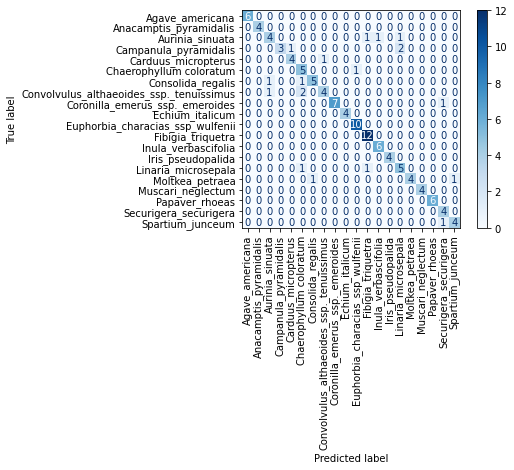

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

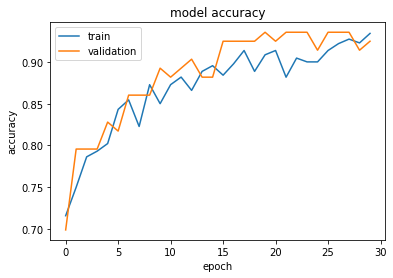

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

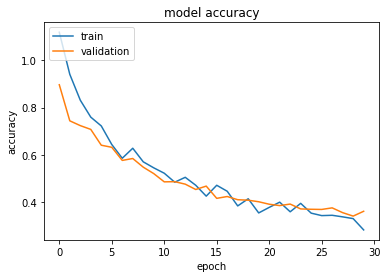

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()